# Ejercicio 2: Comparación de rendimiento entre Pandas y Dask

Este ejercicio compara el tiempo de ejecución y el uso de memoria al leer un archivo CSV grande (~230 MB) usando Pandas y Dask.

### Instalación de Librerías Adicionales

Para este ejercicio, necesitamos instalar dask para el procesamiento en paralelo, requests para descargar el archivo y memory_profiler para medir el uso de memoria.

In [ ]:
# Ejecuta esta celda para instalar las librerías necesarias
%pip install "dask[complete]" memory_profiler requests

Note: you may need to restart the kernel to use updated packages.


### Importación de Librerías

In [ ]:
import pandas as pd
import dask.dataframe as dd
import time
import requests
import os
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

# Configuración para gráficos en línea
%matplotlib inline

### 1. Descarga del Dataset

El siguiente código descargará el archivo `yellow_tripdata_2016-01.csv` y lo guardará en la carpeta `datos/ejer_2/`. La descarga solo se realizará si el archivo no existe.

In [ ]:
# Definir la URL y la ruta de destino del archivo
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00347/yellow_tripdata_2016-01.csv"
datos_dir = os.path.join("..", "datos", "ejer_2")
FILE_PATH = os.path.join(datos_dir, "yellow_tripdata_2016-01.csv")

# Crear el directorio si no existe
os.makedirs(datos_dir, exist_ok=True)

# Descargar el archivo si no existe localmente
if not os.path.exists(FILE_PATH):
    print(f"Descargando archivo (~230 MB) en {FILE_PATH}...")
    r = requests.get(URL, stream=True)
    with open(FILE_PATH, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024*1024):
            f.write(chunk)
    print("Descarga completa.")
else:
    print(f"Archivo ya disponible en {FILE_PATH}.")

Archivo ya disponible en ..\datos\ejer_2\yellow_tripdata_2016-01.csv.


### 2. Definición de Funciones de Lectura

In [ ]:
def pandas_read(path):
    """Lee el CSV completo usando Pandas."""
    return pd.read_csv(path)

def dask_read(path):
    """Define la lectura del CSV con Dask (evaluación perezosa)."""
    return dd.read_csv(path)

### 3. Comparación de Rendimiento

Medimos el tiempo de ejecución y el pico de uso de memoria para leer el archivo con ambas librerías. **Nota:** Esta celda puede tardar varios minutos en ejecutarse y consumir una cantidad significativa de RAM.

In [ ]:
times = {}  # Diccionario para almacenar los tiempos
mem = {}    # Diccionario para almacenar los picos de memoria

print("--- Realizando medición con Pandas ---")
t0 = time.time()
# memory_usage monitorea el uso de memoria de la función pandas_read
mem_p = memory_usage((pandas_read, (FILE_PATH,)), interval=0.1, timeout=240) # Timeout para evitar que se congele indefinidamente
df_p = pandas_read(FILE_PATH)
times['pandas'] = time.time() - t0
mem['pandas'] = max(mem_p) if mem_p else 0
print(f"Medición con Pandas completada. Tiempo: {times['pandas']:.2f}s, Memoria: {mem['pandas']:.2f}MB")

print("\n--- Realizando medición con Dask ---")
t0 = time.time()
# Para Dask, medimos la memoria durante la ejecución real con .compute()
ddf = dask_read(FILE_PATH)
mem_d = memory_usage((ddf.compute,), interval=0.1, timeout=240)
times['dask'] = time.time() - t0
mem['dask'] = max(mem_d) if mem_d else 0
print(f"Medición con Dask completada. Tiempo: {times['dask']:.2f}s, Memoria: {mem['dask']:.2f}MB")

--- Realizando medición con Pandas ---
Medición con Pandas completada. Tiempo: 4.04s, Memoria: 181.05MB

--- Realizando medición con Dask ---
Medición con Pandas completada. Tiempo: 4.04s, Memoria: 181.05MB

--- Realizando medición con Dask ---
Medición con Dask completada. Tiempo: 4.15s, Memoria: 181.09MB
Medición con Dask completada. Tiempo: 4.15s, Memoria: 181.09MB


### 4. Resultados y Visualización

Tiempos de ejecución (segundos): {'pandas': 4.04284405708313, 'dask': 4.153684139251709}
Pico de memoria (MB): {'pandas': 181.046875, 'dask': 181.08984375}


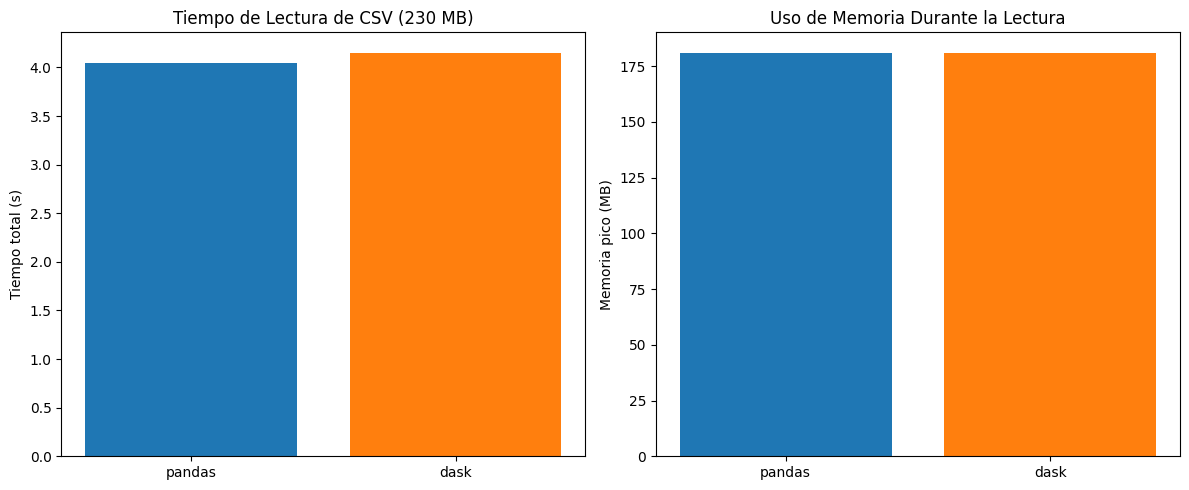

In [ ]:
print("Tiempos de ejecución (segundos):", times)
print("Pico de memoria (MB):", mem)

# Visualización de resultados
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de tiempo
ax[0].bar(times.keys(), times.values(), color=['#1f77b4', '#ff7f0e'])
ax[0].set_ylabel("Tiempo total (s)")
ax[0].set_title("Tiempo de Lectura de CSV (230 MB)")

# Gráfico de memoria
ax[1].bar(mem.keys(), mem.values(), color=['#1f77b4', '#ff7f0e'])
ax[1].set_ylabel("Memoria pico (MB)")
ax[1].set_title("Uso de Memoria Durante la Lectura")

plt.tight_layout()
plt.show()

### 5. Validación de Datos

Para asegurarnos de que ambas librerías leyeron los datos correctamente, calculamos una métrica simple (la media de una columna) y comparamos los resultados.

In [ ]:
# Para validar, calculamos la media de una columna en ambos dataframes
# Primero, obtenemos el dataframe de pandas a partir del de dask
df_d = ddf.compute()

op_p = df_p.passenger_count.mean()
op_d = df_d.passenger_count.mean()

print(f"Media de 'passenger_count' con Pandas: {op_p:.4f}")
print(f"Media de 'passenger_count' con Dask:   {op_d:.4f}")

AttributeError: 'DataFrame' object has no attribute 'passenger_count'